In [1]:
# 安装依赖（如需）
!pip install torch pandas numpy matplotlib tqdm --upgrade

# 导入库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# 设备配置（Kaggle GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备：{device}")

使用设备：cuda


2. 加载数据集（用列索引引用，避免列名问题

In [2]:
# 加载CSV（直接用索引引用列，忽略乱码列名）
df = pd.read_csv("/kaggle/input/chinese-chess/chess.csv")

# 验证数据集形状（应是 (1886358, 5)）
print("数据集形状：", df.shape)

# 给列重命名（方便后续处理）
df.columns = ["pre_board", "action", "post_board", "move_status", "result"]
print("重命名后列名：", df.columns.tolist())

# 查看关键列示例
print("\n走棋前棋盘状态（前10个字符）：", df["pre_board"].iloc[0][:10])
print("动作（4位数字）：", df["action"].iloc[0])
print("对局结果：", df["result"].dropna().iloc[0])

# 从188万数据中随机抽取10万行，random_state=42保证每次采样结果一致
df_sample = df.sample(n=100000, random_state=42)
print(f"采样后数据形状：{df_sample.shape}")  # 验证是否为 (100000, 5)

数据集形状： (1886358, 5)
重命名后列名： ['pre_board', 'action', 'post_board', 'move_status', 'result']

走棋前棋盘状态（前10个字符）： 0919293949
动作（4位数字）： 7062
对局结果： 1.0
采样后数据形状：(100000, 5)


基础解析函数

In [3]:
def parse_position(pos_str):
    """
    将两位数字字符串解析为 (x, y) 坐标，或返回 None（棋子已被吃掉）
    特殊规则："99" → 棋子已被吃掉，返回 None
    正常规则：pos_str = "XY" → x=int(X)（0-8），y=int(Y)（0-9）
    """
    if len(pos_str) != 2:
        return None  # 无效位置，视为棋子被吃掉
    if pos_str == "99":
        return None  # 明确标记：棋子已被吃掉
    try:
        x = int(pos_str[0])
        y = int(pos_str[1])
        if x >= 0 and x <= 8 and y >= 0 and y <= 9:
            return (x, y)
        else:
            return None  # 坐标超出范围，视为无效
    except:
        return None  # 非数字字符串，视为无效

def split_board_str(board_str):
    """将64位棋盘字符串拆分为32个两位数字的位置列表"""
    if len(board_str) != 64:
        raise ValueError(f"棋盘字符串必须是64位：当前{len(board_str)}位")
    # 每两位分割一次
    positions = [board_str[i:i+2] for i in range(0, 64, 2)]
    return positions

棋盘编码（核心适配）

In [17]:
# 定义32个棋子的固定顺序、类型、通道号（全局常量）
PIECE_ORDER = [
    # 红方（16个棋子）：(棋子名称, 通道号)
    ("Red Car", 7),
    ("Red Horse", 8),
    ("Red Phase", 9),
    ("Red Shi", 10),
    ("Red Handsome", 11),
    ("Red Shi", 10),
    ("Red Phase", 9),
    ("Red Horse", 8),
    ("Red Car", 7),
    ("Red Cannon", 12),
    ("Red Cannon", 12),
    ("Red Soldier", 13),
    ("Red Soldier", 13),
    ("Red Soldier", 13),
    ("Red Soldier", 13),
    ("Red Soldier", 13),
    # 黑方（16个棋子）
    ("Black Car", 0),
    ("Black Horse", 1),
    ("Black Aspect", 2),
    ("Black Soldier", 3),  # 士
    ("Black General", 4),
    ("Black Soldier", 3),  # 士
    ("Black Aspect", 2),
    ("Black Horse", 1),
    ("Black Car", 0),
    ("Black Gun", 5),      # 炮
    ("Black Gun", 5),      # 炮
    ("Black Gun", 6),      # 兵
    ("Black Gun", 6),      # 兵
    ("Black Gun", 6),      # 兵
    ("Black Gun", 6),      # 兵
    ("Black Gun", 6),      # 兵
]

def encode_board(board_str):
    """
    将64位棋盘字符串编码为 (16, 9, 10) 张量
    输入：64位字符串（32个两位数字）
    输出：(通道数, 列数x, 行数y) → 16通道（14棋子+1走棋方+1预留）
    """
    board = np.zeros((16, 9, 10), dtype=np.float32)
    positions = split_board_str(board_str)
    
    # 填充棋子通道（32个棋子对应32个位置）
    for idx, (pos_str, (piece_name, channel)) in enumerate(zip(positions, PIECE_ORDER)):
        pos = parse_position(pos_str)
        if pos is not None:  # 只有返回坐标时才标记
            x, y = pos
            board[channel, x, y] = 1.0  # 标记该位置有对应棋子
    
    # 通道14（走棋方）：后续从动作判断（红方动作→1，黑方→0）
    # 通道15（预留）：填充0
    board[15, :, :] = 0.0
    return torch.tensor(board, dtype=torch.float32)

动作编码（适配 4 位数字）

In [15]:
# 构建动作映射（(x1,y1,x2,y2) → 索引）
def build_action_mapping():
    action_list = []
    for x1 in range(9):
        for y1 in range(10):
            for x2 in range(9):
                for y2 in range(10):
                    action_list.append((x1, y1, x2, y2))
    action_to_idx = {action: idx for idx, action in enumerate(action_list)}
    return action_list, action_to_idx

action_list, action_to_idx = build_action_mapping()
num_total_actions = len(action_list)  # 8100

def encode_action(action_num):
    """
    将4位整数动作编码为动作索引
    输入：4位整数（例：7062）
    输出：动作索引（0-8099）
    """
    # 转换为4位字符串（处理可能的前导0，例：762→"0762"）
    action_str = str(action_num).zfill(4)
    if len(action_str) != 4:
        raise ValueError(f"动作必须是4位数字：{action_num}")
    
    # 拆分起始位置和目标位置
    start_pos_str = action_str[:2]  # 前两位是起始位置
    end_pos_str = action_str[2:]    # 后两位是目标位置
    
    # 解析位置
    start_pos = parse_position(start_pos_str)
    end_pos = parse_position(end_pos_str)
    
    if start_pos is None or end_pos is None:
        raise ValueError(f"动作位置无效：{action_num} → 起始位置={start_pos_str}, 目标位置={end_pos_str}")
    
    x1, y1 = start_pos
    x2, y2 = end_pos
    
    # 转换为动作索引
    action = (x1, y1, x2, y2)
    if action not in action_to_idx:
        raise ValueError(f"无效动作坐标：{action}")
    return action_to_idx[action]

def get_legal_actions(board_str):
    """
    简化版合法动作过滤：基于棋子位置和颜色，排除原地不动和己方棋子位置
    （后续可扩展完整象棋规则）
    """
    legal_actions = []
    positions = split_board_str(board_str)
    
    # 提取所有红方棋子的当前位置（前16个）和黑方棋子位置（后16个）
    red_positions = []
    for pos_str in positions[:16]:
        pos = parse_position(pos_str)
        if pos is not None:  # 过滤掉被吃掉的棋子
            red_positions.append(pos)
    
    black_positions = []
    for pos_str in positions[16:]:
        pos = parse_position(pos_str)
        if pos is not None:  # 过滤掉被吃掉的棋子
            black_positions.append(pos)
    
    # 假设当前动作是红方（后续可从动作起始位置判断走棋方）
    # 红方合法动作：起始位置在红方棋子位置，目标位置不在红方棋子位置，且不原地不动
    for (x1, y1) in red_positions:
        for x2 in range(9):
            for y2 in range(10):
                if (x1, y1) == (x2, y2):
                    continue  # 排除原地不动
                if (x2, y2) not in red_positions:  # 排除己方棋子位置
                    action = (x1, y1, x2, y2)
                    legal_actions.append(action_to_idx[action])
    
    return legal_actions

自定义 Dataset 类（适配新解析逻辑）

In [18]:
class ChineseChessSLDataset(Dataset):
    def __init__(self, df):
        self.df = df
        # 过滤无效样本（动作、棋盘解析失败，或结果缺失）
        self.valid_indices = self._filter_valid_samples()
    
    def _filter_valid_samples(self):
        """宽松的样本过滤，确保有足够的训练数据"""
        valid_indices = []
        for idx in tqdm(range(len(self.df)), desc="过滤无效样本"):
            try:
                pre_board = str(self.df.iloc[idx]["pre_board"])
                action = str(self.df.iloc[idx]["action"]).zfill(4)
            
                # 基本检查
                if len(pre_board) >= 60:  # 允许一定的长度偏差
                    # 尝试解析
                    positions = [pre_board[i:i+2] for i in range(0, min(64, len(pre_board)), 2)]
                    if len(positions) >= 30:  # 至少有30个棋子位置
                        if len(action) == 4 and action.isdigit():
                            valid_indices.append(idx)
            except:
                continue
        print(f"有效样本数：{len(valid_indices)}/{len(self.df)}")
        return valid_indices
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        original_idx = self.valid_indices[idx]
        row = self.df.iloc[original_idx]
        
        # 1. 编码棋盘状态（输入特征）
        pre_board = row["pre_board"]
        state = encode_board(pre_board)
        
        # 2. 编码动作标签（目标输出）
        action = row["action"]
        action_idx = encode_action(action)
        
        # 3. 生成合法动作掩码
        legal_action_ids = get_legal_actions(pre_board)
        mask = torch.zeros(num_total_actions, dtype=torch.float32)
        mask[legal_action_ids] = 1.0
        
        # 4. 填充走棋方通道（通道14）：判断动作属于红方还是黑方
        action_str = str(action).zfill(4)
        start_pos_str = action_str[:2]
        
        # 安全解析起始位置
        start_pos = parse_position(start_pos_str)
        if start_pos is None:
            raise ValueError(f"动作起始位置无效: {action_str} → {start_pos_str}")
        start_x, start_y = start_pos
        
        # 过滤掉被吃掉的棋子位置
        red_positions = []
        for pos_str in split_board_str(pre_board)[:16]:
            pos = parse_position(pos_str)
            if pos is not None:
                red_positions.append(pos)
        
        # 判断走棋方
        state[14, :, :] = 1.0 if (start_x, start_y) in red_positions else 0.0
        
        return (
            state.to(device),
            torch.tensor(action_idx, dtype=torch.long).to(device),
            mask.to(device)
        )

# 划分训练集/测试集（8:2）
train_df = df_sample.sample(frac=0.8, random_state=42)
test_df = df_sample.drop(train_df.index)

# 构建DataLoader
batch_size = 64  # Kaggle GPU可调整为128
train_dataset = ChineseChessSLDataset(train_df)
test_dataset = ChineseChessSLDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# 验证数据加载
print(f"\n训练集批次：{len(train_loader)}，测试集批次：{len(test_loader)}")
if len(train_loader) > 0:
    sample_state, sample_action, sample_mask = next(iter(train_loader))
    print(f"样本状态形状：{sample_state.shape}")
    print(f"样本动作标签：{sample_action[:5]}")
    print(f"单样本合法动作数：{sample_mask[0].sum().item()}")

过滤无效样本: 100%|██████████| 80000/80000 [00:06<00:00, 13121.97it/s]


有效样本数：80000/80000


过滤无效样本: 100%|██████████| 20000/20000 [00:01<00:00, 13513.21it/s]


有效样本数：20000/20000

训练集批次：1250，测试集批次：312
样本状态形状：torch.Size([64, 16, 9, 10])
样本动作标签：tensor([ 454, 3914, 2007, 5013, 4377], device='cuda:0')
单样本合法动作数：1001.0


模型、训练函数（不变，直接复用）

In [21]:
# 策略网络
class ChessPolicyNet(nn.Module):
    def __init__(self, num_actions=8100):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 9 * 10, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_actions),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x, mask=None):
        features = self.conv_layers(x)
        action_probs = self.fc_layers(features)
        if mask is not None:
            action_probs = action_probs * mask
            action_probs = action_probs / (action_probs.sum(dim=1, keepdim=True) + 1e-8)
        return action_probs

# 初始化模型、损失函数、优化器
model = ChessPolicyNet(num_actions=num_total_actions).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 修改这里：mode 只能是 'min' 或 'max'
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',       # 监控验证损失，越小越好
    patience=3,       # 3个epoch没有改善就降低学习率
    factor=0.5,       # 学习率变为原来的0.5倍
    
)

# 训练与评估函数
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for batch in tqdm(loader, desc="训练"):
        states, action_labels, masks = batch
        action_probs = model(states, masks)
        loss = criterion(torch.log(action_probs + 1e-8), action_labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item() * states.size(0)
        pred_actions = torch.argmax(action_probs, dim=1)
        total_correct += (pred_actions == action_labels).sum().item()
        total_samples += states.size(0)
    return total_loss/total_samples, total_correct/total_samples

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="测试"):
            states, action_labels, masks = batch
            action_probs = model(states, masks)
            loss = criterion(torch.log(action_probs + 1e-8), action_labels)
            
            total_loss += loss.item() * states.size(0)
            pred_actions = torch.argmax(action_probs, dim=1)
            total_correct += (pred_actions == action_labels).sum().item()
            total_samples += states.size(0)
    return total_loss/total_samples, total_correct/total_samples

训练循环与可视化


===== Epoch 1/5 =====


训练: 100%|██████████| 1250/1250 [01:35<00:00, 13.05it/s]


训练损失：7.2995 | 训练准确率：0.068350


测试: 100%|██████████| 312/312 [00:20<00:00, 15.13it/s]


测试损失：6.3157 | 测试准确率：0.086789 | 当前最佳准确率：0.000000
✅ 保存最优模型（准确率：0.086789，Epoch：1）
📌 保存当前epoch模型（Epoch：1，准确率：0.086789）

===== Epoch 2/5 =====


训练: 100%|██████████| 1250/1250 [01:34<00:00, 13.17it/s]


训练损失：6.1449 | 训练准确率：0.105737


测试: 100%|██████████| 312/312 [00:20<00:00, 15.14it/s]


测试损失：6.1957 | 测试准确率：0.099860 | 当前最佳准确率：0.086789
✅ 保存最优模型（准确率：0.099860，Epoch：2）
📌 保存当前epoch模型（Epoch：2，准确率：0.099860）

===== Epoch 3/5 =====


训练: 100%|██████████| 1250/1250 [01:34<00:00, 13.18it/s]


训练损失：5.8726 | 训练准确率：0.150287


测试: 100%|██████████| 312/312 [00:20<00:00, 15.03it/s]


测试损失：6.1533 | 测试准确率：0.108824 | 当前最佳准确率：0.099860
✅ 保存最优模型（准确率：0.108824，Epoch：3）
📌 保存当前epoch模型（Epoch：3，准确率：0.108824）

===== Epoch 4/5 =====


训练: 100%|██████████| 1250/1250 [01:34<00:00, 13.22it/s]


训练损失：5.6069 | 训练准确率：0.201513


测试: 100%|██████████| 312/312 [00:20<00:00, 15.12it/s]


测试损失：6.1558 | 测试准确率：0.109425 | 当前最佳准确率：0.108824
✅ 保存最优模型（准确率：0.109425，Epoch：4）
📌 保存当前epoch模型（Epoch：4，准确率：0.109425）

===== Epoch 5/5 =====


训练: 100%|██████████| 1250/1250 [01:34<00:00, 13.21it/s]


训练损失：5.3568 | 训练准确率：0.258725


测试: 100%|██████████| 312/312 [00:21<00:00, 14.84it/s]


测试损失：6.2642 | 测试准确率：0.110477 | 当前最佳准确率：0.109425
✅ 保存最优模型（准确率：0.110477，Epoch：5）
📌 保存当前epoch模型（Epoch：5，准确率：0.110477）


/tmp/ipykernel_55/3335315573.py:78: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/3335315573.py:78: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/3335315573.py:78: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/3335315573.py:78: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/3335315573.py:78: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/3335315573.py:78: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55/3335315573.py:78: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from

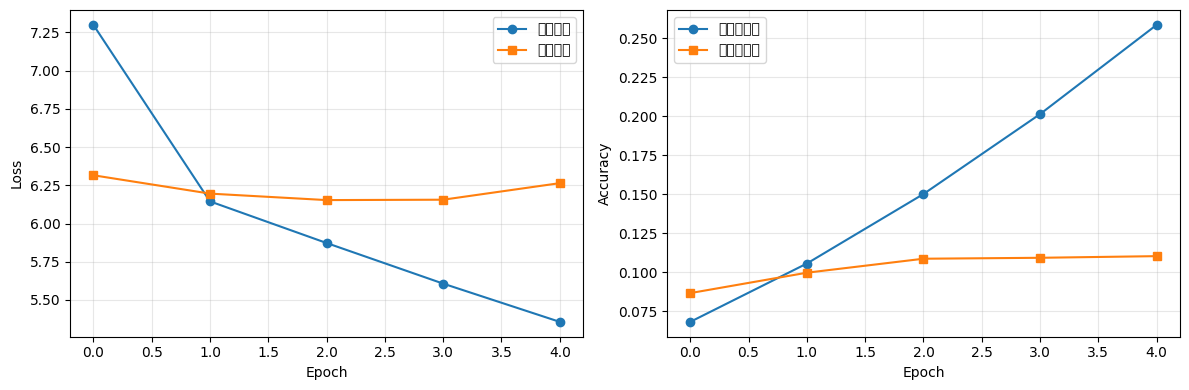


🎉 成功加载最优模型：准确率 0.110477，Epoch 5


In [22]:
num_epochs = 5
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
    
    # 训练
    if len(train_loader) > 0:
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"训练损失：{train_loss:.4f} | 训练准确率：{train_acc:.6f}")  # 显示6位小数，避免漏看低准确率
    else:
        print("❌ 训练集为空，跳过训练")
        continue
    
    # 测试
    if len(test_loader) > 0:
        val_loss, val_acc = evaluate(model, test_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"测试损失：{val_loss:.4f} | 测试准确率：{val_acc:.6f} | 当前最佳准确率：{best_val_acc:.6f}")
        
        # 学习率衰减
        scheduler.step(val_loss)
        
        # 保存最优模型（原逻辑保留）
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                "model_state_dict": model.state_dict(),
                "best_val_acc": best_val_acc,
                "epoch": epoch+1,  # 新增：记录保存时的epoch
                "train_loss": train_loss,
                "val_loss": val_loss
            }, "best_chinese_chess_sl_model.pth")
            print(f"✅ 保存最优模型（准确率：{best_val_acc:.6f}，Epoch：{epoch+1}）")
        
        # 强制保存：每个epoch结束都保存一个“最新模型”（用于调试/防止训练中断）
        torch.save({
            "model_state_dict": model.state_dict(),
            "current_val_acc": val_acc,
            "epoch": epoch+1
        }, "latest_chinese_chess_sl_model.pth")
        print(f"📌 保存当前epoch模型（Epoch：{epoch+1}，准确率：{val_acc:.6f}）")
        
    else:
        print("❌ 测试集为空，跳过测试")
        # 即使没有测试集，也强制保存训练后的模型
        torch.save({
            "model_state_dict": model.state_dict(),
            "train_acc": train_acc,
            "epoch": epoch+1
        }, "latest_chinese_chess_sl_model_no_test.pth")
        print(f"📌 无测试集，保存训练后模型（Epoch：{epoch+1}，训练准确率：{train_acc:.6f}）")

# 绘制训练曲线（不变）
if train_losses and val_losses:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="训练损失", marker='o')
    plt.plot(val_losses, label="测试损失", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="训练准确率", marker='o')
    plt.plot(val_accs, label="测试准确率", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 加载最优模型（优化：无论是否保存成功，都尝试加载）
try:
    best_checkpoint = torch.load("best_chinese_chess_sl_model.pth", map_location=device)
    model.load_state_dict(best_checkpoint["model_state_dict"])
    print(f"\n🎉 成功加载最优模型：准确率 {best_checkpoint['best_val_acc']:.6f}，Epoch {best_checkpoint['epoch']}")
except FileNotFoundError:
    print("\n⚠️  未找到最优模型文件，尝试加载最新epoch模型...")
    try:
        latest_checkpoint = torch.load("latest_chinese_chess_sl_model.pth", map_location=device)
        model.load_state_dict(latest_checkpoint["model_state_dict"])
        print(f"🎉 成功加载最新模型：准确率 {latest_checkpoint['current_val_acc']:.6f}，Epoch {latest_checkpoint['epoch']}")
    except FileNotFoundError:
        print("❌ 未找到任何模型文件，请检查训练是否正常执行！")